In [30]:
import numpy as np
import pandas as pd
import MLP
import matplotlib.pyplot as plt
import torch
import time
import importlib
importlib.reload(MLP)
import seaborn as sns
import os 


In [2]:
def create_dataset(filename: str) -> tuple[pd.DataFrame, pd.DataFrame, pd.DataFrame]:
    # read data
    df = pd.read_csv(filename)

    # split data
    x, y_noise, y_true = df['x'], df['y_noise'], df['y_true']
    return x, y_noise, y_true

In [3]:
def evaluate_model(cfg : dict, foldername : str) -> dict:
    results = {"train_loss": [], "test_loss": 0, "x_train": [], "y_train": [], "x_test": [],
                "y_test": [], "y_train_pred": [], "y_test_pred": [], "x_plot_trainvals": [], "x_plot_testvals": [],}
    # get configs
    model_name = cfg["name"]
    input_size = cfg["input_size"]
    hidden_sizes = cfg["hidden_sizes"]
    output_size = cfg["output_size"]
    n_epochs = cfg["n_epochs"]
    
    train_file = f"{foldername}/train_data.csv"
    test_file = f"{foldername}/test_data.csv"
    val_file = f"{foldername}/validation_data.csv"
    # create dataset
    train_data= create_dataset(train_file)
    test_data = create_dataset(test_file)
    val_data = create_dataset(val_file)
    true_vals = create_dataset(f"{foldername}/true_data.csv")
    # change x-values to shape (n, 1)
    x_train = torch.tensor(train_data[1].values.reshape(len(train_data[1]), 1)).float()
    y_train = torch.tensor(train_data[2].values.reshape(len(train_data[1]), 1)).float()
    x_test = torch.tensor(test_data[1].values.reshape(len(test_data[1]), 1)).float().view(-1, 1)
    y_test = torch.tensor(test_data[2].values.reshape(len(test_data[1]), 1)).float()
    x_val = torch.tensor(val_data[1].values.reshape(len(val_data[1]), 1)).float().view(-1, 1)
    y_val = torch.tensor(val_data[2].values.reshape(len(val_data[1]), 1)).float()

    x_plot_trainvals = train_data[0]
    x_plot_testvals = test_data[0]
    x_plot_valvals = val_data[0]


    # append to results
    results["x_train"] = x_train
    results["y_train"] = y_train
    results["x_test"] = x_test
    results["y_test"] = y_test
    results["x_val"] = x_val
    results["y_val"] = y_val
    results["x_plot_trainvals"] = x_plot_trainvals
    results["x_plot_testvals"] = x_plot_testvals
    results["x_plot_valvals"] = x_plot_valvals
    results["true_data_x"] = true_vals[0]
    results["true_data_ynoise"] = true_vals[1]
    results["true_data_y"] = true_vals[2]


    # train model
    model = MLP.MLP(input_size, hidden_sizes, output_size)
    # set val data
    model.set_val_data(x_val, y_val)

    start = time.time()
    model.fit(x_train,y_train,n_epochs)
    end = time.time()
    print(f"Training time for model: {model_name} was: {end - start}")
    results["training_time"] = end - start
    results["train_loss"] = model.loss_list
    results["val_loss"] = model.val_loss_list


    # test loss
    y_pred = model.predict(x_test)
    results["y_val_pred"] = model.predict(x_val)
    test_loss = model.loss_function(y_pred, y_test)
    results["test_loss"] = test_loss
    results["y_test_pred"] = y_pred
    print(f"Test loss for model: {model_name} was: {test_loss}")

    # append to results
    results["y_train_pred"] = model.predict(x_train)

    return results

In [ ]:
configs = [
    {"name": "model1",
    "input_size" : 1,
    "hidden_sizes" : [8,8],
    "output_size" : 1,
    "n_epochs": 5000},
    
    {"name": "model2",
    "input_size" : 1,
    "hidden_sizes" : [25,25,25, 25],
    "output_size" : 1,
    "n_epochs": 5000}
]
results = {}
foldername = "../datasets/pink_sin_test2"
for cfg in configs:
    if cfg["name"] not in results:
        results[cfg["name"]] = {}
    results[cfg["name"]] = evaluate_model(cfg, foldername)

100%|██████████| 4999/4999 [00:02<00:00, 2350.65it/s]


Training time for model: model1 was: 2.145944833755493
Test loss for model: model1 was: 0.03443446755409241


100%|██████████| 4999/4999 [00:03<00:00, 1518.91it/s]

Training time for model: model2 was: 3.2928168773651123
Test loss for model: model2 was: 0.037053316831588745


In [69]:
def plot_model(model_cfg, model_res : dict, model_name) -> None:


    #
    width = model_cfg["hidden_sizes"] 
    folder_name = f'{model_name}_uniform_sin(x)_{width}_241114_2' #save folder name, one for each model run
    os.makedirs(f'./results/{folder_name}', exist_ok=True)


    # Create a figure with two subplots side by side
    #fig, ax = plt.subplots(1, 2, figsize=(16, 6))
    X_val = model_res["x_plot_valvals"]
    KAN_preds = model_res["y_val_pred"]
    y_noise_val = model_res["x_val"]
    X_tot = model_res["true_data_x"]
    y_true_tot = model_res["true_data_y"]
    plt.plot(X_val, y_noise_val, "o", markersize=1, linestyle='None', label="val data")
    plt.plot(X_tot, y_true_tot, "-",label='True function')
    #ax[0].plot(X, y_true, "-",label='True trained function')

    # Sort the values for better visualization
    indices = X_val.argsort()
    sorted_X = X_val[indices]

    # sort the predictions using the same indices as the sorted X values
    sorted_KAN_preds = KAN_preds[indices]

    #print("sorted_KAN_preds",sorted_KAN_preds.shape)
    plt.plot(sorted_X, sorted_KAN_preds, "--", label='KAN predictions')

    #noise_x = np.linspace(-10, 10, 1000)
    #noise_combined = 0.0001*noise_x#np.sin(noise_x) + np.sin(0.2 * noise_x)
    

    plt.xlabel("Random X 1D samples")
    plt.ylabel("Function")
    plt.title("Prediction using MLP", fontsize=14, weight='bold')
    plt.legend()

    plt.tight_layout()
    plt.savefig(f'./results/{folder_name}/plot.png', dpi=300)

    plt.clf()

    # --- Plot 2: Training and Validation Loss ---
    # Convert loss data to a DataFrame for Seaborn
    loss_df = pd.DataFrame({
        'Epoch': range(1, len(model_res['train_loss']) + 1),
        'Train Loss': model_res['train_loss'],
        'Validation Loss': model_res['val_loss']
    })

    # Ensure correct data types
    loss_df['Epoch'] = loss_df['Epoch'].astype(int)
    loss_df['Train Loss'] = loss_df['Train Loss'].astype(float)
    loss_df['Validation Loss'] = loss_df['Validation Loss'].astype(float)
    
    # Melt the DataFrame for easier plotting with Seaborn
    loss_melted = loss_df.melt(id_vars='Epoch', var_name='Loss Type', value_name='Loss')

    # Debugging: Inspect the melted DataFrame
    print("Melted Loss DataFrame:")
    print(loss_melted.head())

    # Line plot for training and validation loss, with no fancy stuff
    sns.lineplot(data=loss_melted, x='Epoch', y='Loss', hue='Loss Type')

    # Set labels and title
    plt.xlabel("Epoch", fontsize=12)
    plt.ylabel("Loss", fontsize=12)
    plt.title("Training and Validation Loss Over Epochs", fontsize=14, weight='bold')

    # Customize legend
    plt.legend(title='Loss Type', fontsize=10, title_fontsize=12)

    # Adjust layout for better spacing
    plt.tight_layout()
    plt.savefig(f'./results/{folder_name}/loss.png', dpi=300)

    # Optional: Save the figure with high resolution
    # plt.savefig('enhanced_plots.png', dpi=300)

    # Display the plots

    #plt.show()

    file_path = f'./results/{folder_name}/MLP_model_params.txt'


    width = model_cfg["hidden_sizes"]
    steps = model_cfg["n_epochs"]


    with open(file_path, "w") as file:
        file.write(f"input to model: y_noise, y_true (fixed)\n")
        file.write(f"width: {width}\n")
        file.write(f"opt: Adam (fixed)\n")
        file.write(f"steps: {steps}\n")
        file.write(f"lr: 0.01 (fixed)\n")
        file.write(f"final validation loss: {loss_df['Validation Loss'].iloc[-1]}\n")
        file.write(f"final training loss: {loss_df['Train Loss'].iloc[-1]}\n")



    #variabel_namn = results["variabel_namn"]        
    np.savez(f'./results/{folder_name}/MLP_plots.npz', epoch=range(1, len(model_res['train_loss']) + 1), train_loss = model_res['train_loss'], val_loss = model_res['test_loss'] , X_val = model_res["x_plot_valvals"], y_noise_val = model_res["x_val"], X_tot = model_res["true_data_x"],y_true_tot = model_res["true_data_y"], sorted_X = sorted_X, sorted_KAN_preds = sorted_KAN_preds)
    


Melted Loss DataFrame:
   Epoch   Loss Type      Loss
0      1  Train Loss  0.504062
1      2  Train Loss  0.484554
2      3  Train Loss  0.467818
3      4  Train Loss  0.453533
4      5  Train Loss  0.439829


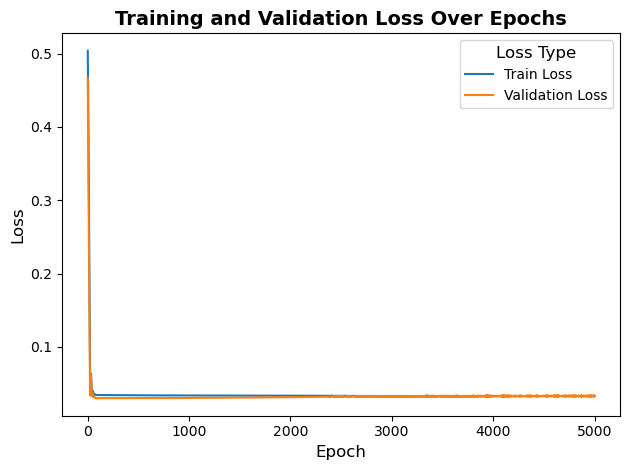

In [70]:
plot_model(configs[0], results["model1"], model_name='model1')

(100,)
(100, 1)
(100, 1)
(4999,)
(4999,)
()


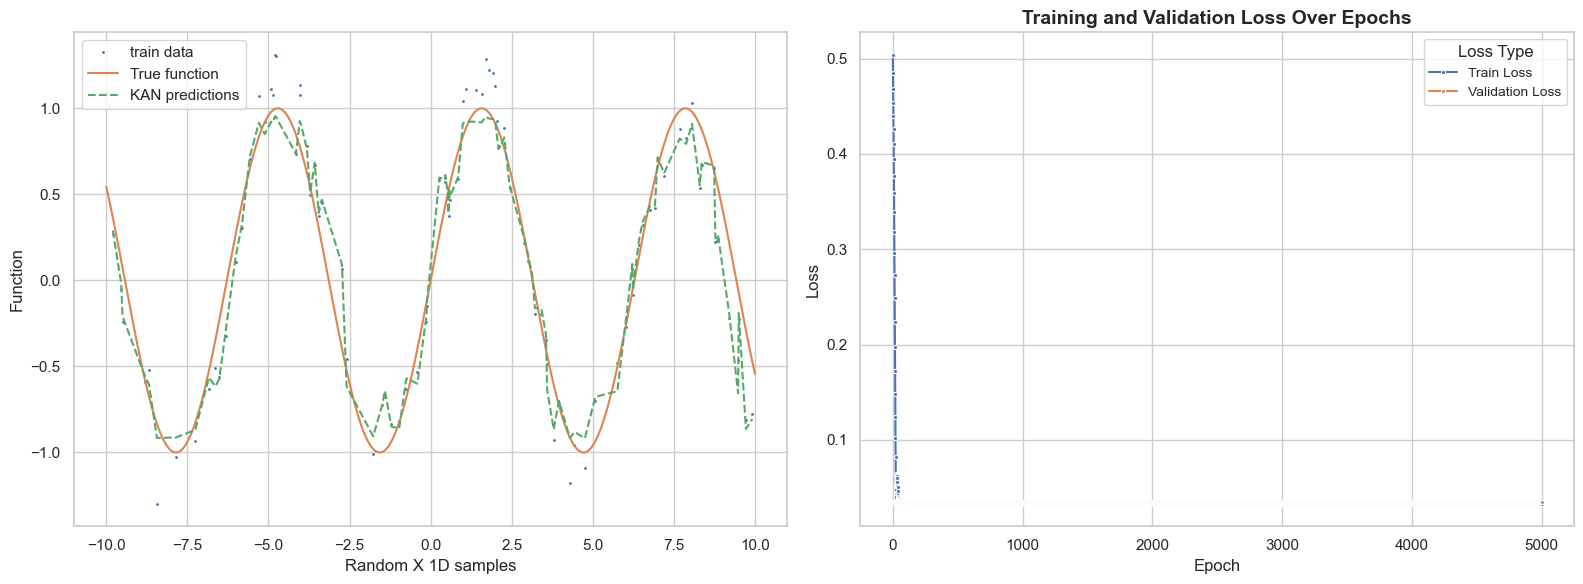

In [73]:
data = np.load("./results/model1_uniform_sin(x)_[8, 8]_241114_2/MLP_plots.npz", allow_pickle=True)

print(data["X_val"].shape)
print(data["y_noise_val"].shape)
print(data["sorted_KAN_preds"].shape)
print(data["epoch"].shape)
print(data["train_loss"].shape)
print(data["val_loss"].shape)



loss_df = pd.DataFrame({
        'Epoch': data["epoch"],
        'Train Loss': data["train_loss"],
        'Validation Loss': data["val_loss"]})

loss_melted = loss_df.melt(id_vars='Epoch', var_name='Loss Type', value_name='Loss')

sns.set_theme(style="whitegrid")

fig, ax = plt.subplots(1, 2, figsize=(16, 6))

ax[0].plot(data["X_val"], data["y_noise_val"], marker='o', markersize=1, linestyle='None', label="train data")
ax[0].plot(data["X_tot"], data["y_true_tot"], linestyle='-',label='True function')

sorted_X = data["sorted_X"]
sorted_KAN_preds = data["sorted_KAN_preds"]


#print("sorted_KAN_preds",sorted_KAN_preds.shape)
ax[0].plot(sorted_X, sorted_KAN_preds, "--", label='KAN predictions')

ax[0].set_xlabel("Random X 1D samples")
ax[0].set_ylabel("Function")
ax[0].legend()



sns.lineplot(data=loss_melted, x='Epoch', y='Loss', hue='Loss Type',
                 ax=ax[1], marker='.')

# Set labels and title
ax[1].set_xlabel("Epoch", fontsize=12)
ax[1].set_ylabel("Loss", fontsize=12)
ax[1].set_title("Training and Validation Loss Over Epochs", fontsize=14, weight='bold')

# Customize legend
ax[1].legend(title='Loss Type', fontsize=10, title_fontsize=12)

# Adjust layout for better spacing
plt.tight_layout()

# Optional: Save the figure with high resolution
# plt.savefig('enhanced_plots.png', dpi=300)

# Display the plots
plt.show()

In [7]:
temp = results["model1"]["y_test_pred"]
temp2 = results["model1"]["y_test"]

print(temp)
print("---------")
print(temp2)

tensor([[-0.8574],
        [ 0.7841],
        [ 0.1756],
        [-0.5689],
        [ 0.9291],
        [-0.8634],
        [ 0.5139],
        [-0.0227],
        [-0.3059],
        [ 0.9553],
        [-0.2549],
        [-0.8459],
        [-0.1462],
        [ 0.9153],
        [-0.0782],
        [ 0.9662],
        [ 0.6591],
        [-0.3250],
        [ 0.9323],
        [-0.8724],
        [ 0.9083],
        [ 0.9305],
        [ 0.1987],
        [ 0.5354],
        [-0.8903],
        [ 0.7656],
        [ 0.5531],
        [ 0.9046],
        [ 0.9635],
        [ 0.9369],
        [-0.7430],
        [-0.8530],
        [ 0.1635],
        [ 0.8538],
        [ 0.1847],
        [ 0.4393],
        [-0.6091],
        [ 0.4510],
        [ 0.8158],
        [-0.2518],
        [ 0.9159],
        [ 0.1885],
        [ 0.8563],
        [ 0.3508],
        [-0.9157],
        [-0.6217],
        [ 0.1910],
        [ 0.7619],
        [ 0.9244],
        [-0.5999],
        [-0.9173],
        [-0.7500],
        [-0.